In [ ]:
# ---------- Install necessary packages ----------
%pip install numpy pandas opencv-python scikit-learn matplotlib tqdm pillow timm pyyaml joblib 
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu129

In [2]:
# ---------- Import necessary libraries ----------
import json, pickle
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
import timm

c:\Users\Hamad\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# ---------- Device setup and check GPU availability ----------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    print("CUDA is available! Training on GPU...")
else:
    print("CUDA is not available. Training on CPU...")

NVIDIA GeForce RTX 5070 Ti
CUDA is available! Training on GPU...


In [4]:
# ---------- Variables Declaration ----------
ROOT = Path(".")  # Project-Code root
CSV_FALL = ROOT / "FallDetectionLabels.csv"
CSV_GEST = ROOT / "HandGestureLabels.csv"

DATASET_DIR = ROOT / "Dataset"
OUT_FALL = ROOT / "Processed Dataset" / "ProcessedFallDetection"
OUT_GEST = ROOT / "Processed Dataset" / "ProcessedHandGesture"

PROCESSED_CSV_FALL = ROOT / "ProcessedFallDetection.csv"
PROCESSED_CSV_GEST = ROOT / "ProcessedHandGesture.csv"

SAMPLE_EVERY = 1
OUT_SIZE = 600  # EfficientNet-B7 scale
OVERWRITE = False
VIDEO_EXTS = [".mp4", ".avi", ".mov", ".mkv", ".MP4", ".AVI", ".MOV", ".MKV"]

In [5]:
# Video preprocessing script to convert videos to motion images

# ---------- utils ----------
def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

# resolve video path function
def resolve_video_path(rel_path: str) -> Path:
    """Resolve a relative CSV path to an actual video file.
    Accepts with or without extension, or a dir containing a single video."""
    p = ROOT / rel_path
    if p.is_file():
        return p

    # try adding common extensions if no suffix
    if p.suffix == "":
        for ext in VIDEO_EXTS:
            cand = p.with_suffix(ext)
            if cand.is_file():
                return cand

    # if it's a directory, pick the first known video
    if p.is_dir():
        for ext in VIDEO_EXTS:
            vids = sorted(p.glob(f"*{ext}"))
            if vids:
                return vids[0]

    raise FileNotFoundError(f"Video not found for entry: {rel_path}")

# pad image to square function
def pad_to_square(img: np.ndarray) -> np.ndarray:
    h, w = img.shape[:2]
    s = max(h, w)
    top = (s - h) // 2
    bottom = s - h - top
    left = (s - w) // 2
    right = s - w - left
    return cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)

# main video processing function, video to motion image
def process_video_to_motion_image(video_path: Path, sample_every: int = 5, out_size: int = 600) -> np.ndarray:
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise RuntimeError(f"Failed to open {video_path}")

    sampled = []
    idx = 0
    while True:
        ok, frame = cap.read()
        if not ok:
            break
        if idx % sample_every == 0:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.float32)
            sampled.append(gray)
        idx += 1
    cap.release()

    if len(sampled) < 2:
        raise RuntimeError(f"Not enough sampled frames ({len(sampled)}) in {video_path}")

    acc = np.zeros_like(sampled[0], dtype=np.float32)
    prev = sampled[0]
    for cur in sampled[1:]:
        diff = np.abs(cur - prev)
        thr = np.percentile(diff, 99) # threshold to reduce noise
        mask = diff >= thr
        acc[mask] += diff[mask]
        prev = cur

    m = acc.max()
    if m > 0:
        acc = acc / m
    acc = (acc * 255.0).clip(0, 255).astype(np.uint8)

    acc = pad_to_square(acc)
    acc = cv2.resize(acc, (out_size, out_size), interpolation=cv2.INTER_AREA)

    # stack grayscale to 3 channels for EfficientNet
    img3 = np.stack([acc, acc, acc], axis=2)
    return img3

# output path mapping function
def target_path_for_output(out_root: Path, rel_video_path: str, ext: str = ".png") -> Path:
    """Write directly under the processed root without an extra Dataset/HandGesture or Dataset/FallDetection level.
    Example:
      Dataset/HandGesture/CurtainGesture/Hamad/CGH1.mp4
      -> OUT_GEST/CurtainGesture/Hamad/CGH1.png
    """
    rel = Path(rel_video_path)
    parts = list(rel.parts)

    # strip leading 'Dataset'
    if parts and parts[0].lower() == "dataset":
        parts = parts[1:]

    # also strip the next level if it is HandGesture or FallDetection
    if parts and parts[0].lower() in ("handgesture", "falldetection"):
        parts = parts[1:]

    rel_no_ext = Path(*parts).with_suffix(ext)
    return out_root / rel_no_ext

# process a dataframe table
def process_table(df: pd.DataFrame, out_root: Path, has_user: bool) -> pd.DataFrame:
    records, failures = [], []

    for row in tqdm(df.itertuples(index=False), total=len(df)):
        rel_path = getattr(row, "video_path")
        label = getattr(row, "label")
        user_id = getattr(row, "user_id") if has_user else None

        try:
            abs_video = resolve_video_path(rel_path)
            out_img = target_path_for_output(out_root, rel_path, ext=".png")
            ensure_dir(out_img.parent)

            if OVERWRITE or not out_img.exists():
                img = process_video_to_motion_image(abs_video, sample_every=SAMPLE_EVERY, out_size=OUT_SIZE)
                ok = cv2.imwrite(str(out_img), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
                if not ok:
                    raise RuntimeError("cv2.imwrite failed")

            rel_img = out_img.relative_to(ROOT).as_posix()
            rec = {"image_path": rel_img, "label": label, "video_path": rel_path}
            if has_user:
                rec["user_id"] = user_id
            records.append(rec)

        except Exception as e:
            failures.append({"video_path": rel_path, "label": label, "error": str(e)})

    if failures:
        fail_csv = out_root / "processing_failures.csv"
        pd.DataFrame(failures).to_csv(fail_csv, index=False)

    return pd.DataFrame(records)


# ---------- run preprocessing ----------
ensure_dir(OUT_FALL)
ensure_dir(OUT_GEST)

if CSV_FALL.exists():
    df_fall = pd.read_csv(CSV_FALL)
    out_fall_df = process_table(df_fall, OUT_FALL, has_user=False)
    out_fall_df.to_csv(PROCESSED_CSV_FALL, index=False)
else:
    print(f"Missing CSV: {CSV_FALL}")

if CSV_GEST.exists():
    df_gest = pd.read_csv(CSV_GEST)
    out_gest_df = process_table(df_gest, OUT_GEST, has_user=True)
    out_gest_df.to_csv(PROCESSED_CSV_GEST, index=False)
else:
    print(f"Missing CSV: {CSV_GEST}")

print("Preprocessing done.")

100%|██████████| 160/160 [00:00<00:00, 4338.98it/s]

Preprocessing done.


In [6]:
# ---------- Variable Declaration ----------
FEATURES_ROOT = ROOT / "Features" / "EffLite0"  
OUT_FEAT_FALL_DIR = FEATURES_ROOT / "FallDetection"
OUT_FEAT_GEST_DIR = FEATURES_ROOT / "HandGesture"
MAP_CSV_FALL = ROOT / "FallDetectionFeaturesEffLite0.csv"
MAP_CSV_GEST = ROOT / "HandGestureFeaturesEffLite0.csv"

FEATURE_DIM = 1280
BATCH_SIZE = 2
NUM_WORKERS = 0
OVERWRITE_FEATURES = False  # set False to skip existing
SEED = 42

In [7]:
# --- Feature extraction with EfficientNet-B7 (timm) ---

# Model (separate name to avoid clashing with later training models)
# feat_model = timm.create_model("tf_efficientnet_b7", pretrained=True, num_classes=0, global_pool="avg")  # 2560-d
feat_model = timm.create_model("tf_efficientnet_lite0", pretrained=True, num_classes=0, global_pool="avg") # 1280-d
feat_model.eval().to(device)

# Images are already 600x600, 3ch; no resize here
extract_tform = transforms.Compose([
    transforms.ToTensor(),  # HWC uint8 -> CHW float in [0,1]
    transforms.Resize((320, 320)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Processed Dataset class
class ProcessedImageDataset(Dataset):
    def __init__(self, csv_path: Path, root: Path, has_user: bool):
        self.df = pd.read_csv(csv_path)
        self.root = root
        self.has_user = has_user
        self.has_user_col = "user_id" in self.df.columns
        self.has_video_col = "video_path" in self.df.columns

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_rel = row["image_path"]
        img_abs = self.root / img_rel
        bgr = cv2.imread(str(img_abs), cv2.IMREAD_COLOR)
        if bgr is None:
            raise FileNotFoundError(f"Missing image: {img_abs}")
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        x = extract_tform(rgb)

        label = row["label"]
        user = row["user_id"] if (self.has_user and self.has_user_col) else ""
        vpath = row["video_path"] if self.has_video_col else ""
        return x, img_rel, label, user, vpath

# path mapping function
def feature_path_for_image(out_root: Path, image_rel_path: str) -> Path:
    """
    Map processed image path to features root, removing:
      'Processed Dataset' and the dataset-specific level.
    """
    rel = Path(image_rel_path)
    parts = list(rel.parts)
    if parts and parts[0].lower() == "processed dataset":
        parts = parts[1:]
    if parts and parts[0].lower() in ("processedhandgesture", "processedfalldetection"):
        parts = parts[1:]
    rel_no_ext = Path(*parts).with_suffix(".npy")
    return out_root / rel_no_ext

# feature extraction function
@torch.no_grad()
def extract_and_save_features(csv_in: Path, out_dir: Path, map_csv_out: Path, has_user: bool):
    out_dir.mkdir(parents=True, exist_ok=True)
    FEATURES_ROOT.mkdir(parents=True, exist_ok=True)

    ds = ProcessedImageDataset(csv_in, ROOT, has_user=has_user)
    g = torch.Generator(device="cpu"); g.manual_seed(SEED)
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True, generator=g)

    records, skipped = [], 0

    for xb, img_rels, labels, users, vpaths in tqdm(loader, total=len(loader)):
        xb = xb.to(device, non_blocking=True)
        with torch.amp.autocast("cuda", enabled=(device.type == "cuda")):
            feats = feat_model(xb)  # [B, 2560]
        feats = feats.float().cpu().numpy()

        for i in range(len(img_rels)):
            img_rel = img_rels[i]
            feat_path = feature_path_for_image(out_dir, img_rel)
            feat_path.parent.mkdir(parents=True, exist_ok=True)

            if not OVERWRITE_FEATURES and feat_path.exists():
                skipped += 1
            else:
                np.save(feat_path, feats[i])

            rec = {
                "image_path": img_rel,
                "feature_path": feat_path.relative_to(ROOT).as_posix(),
                "label": labels[i],
            }
            if has_user:
                rec["user_id"] = users[i]
            if vpaths[i]:
                rec["video_path"] = vpaths[i]
            records.append(rec)

    pd.DataFrame(records).to_csv(map_csv_out, index=False)
    print(f"Saved: {map_csv_out} | Skipped existing: {skipped}")

# ---- run both datasets (uses existing PROCESSED_CSV_* vars) ----
if PROCESSED_CSV_FALL.exists():
    extract_and_save_features(PROCESSED_CSV_FALL, OUT_FEAT_FALL_DIR, MAP_CSV_FALL, has_user=False)
else:
    print(f"Missing {PROCESSED_CSV_FALL}")

if PROCESSED_CSV_GEST.exists():
    extract_and_save_features(PROCESSED_CSV_GEST, OUT_FEAT_GEST_DIR, MAP_CSV_GEST, has_user=True)
else:
    print(f"Missing {PROCESSED_CSV_GEST}")

print("Feature extraction finished.")

100%|██████████| 50/50 [00:02<00:00, 17.48it/s]


Saved: FallDetectionFeaturesEffLite0.csv | Skipped existing: 100


100%|██████████| 80/80 [00:01<00:00, 63.82it/s]

Saved: HandGestureFeaturesEffLite0.csv | Skipped existing: 160
Feature extraction finished.


Rows in mapping: 100
Missing files: 0
Bad shapes: 100  expected (1280,)
NaN or Inf vectors: 0
Example bad shape: [('Features/MNASNet/FallDetection/Falling/FDF1.npy', (1000,)), ('Features/MNASNet/FallDetection/Falling/FDF2.npy', (1000,)), ('Features/MNASNet/FallDetection/Falling/FDF3.npy', (1000,))]
Image: Processed Dataset/ProcessedFallDetection/Standing/FDSD4.png
Label: fall
Feature shape: (1000,)
First 20 values: [-0.4622 -0.4451 -0.0923  0.3157  0.3604 -0.3757  0.0029  0.6909  0.6318
 -0.3213 -0.0458 -0.2656 -0.1851 -0.3164 -0.3726 -0.0828 -0.2485 -0.2676
 -0.303  -0.3064]
Stats min max mean std: -0.99072265625 2.083984375 0.0001270542124984786 0.4756785035133362


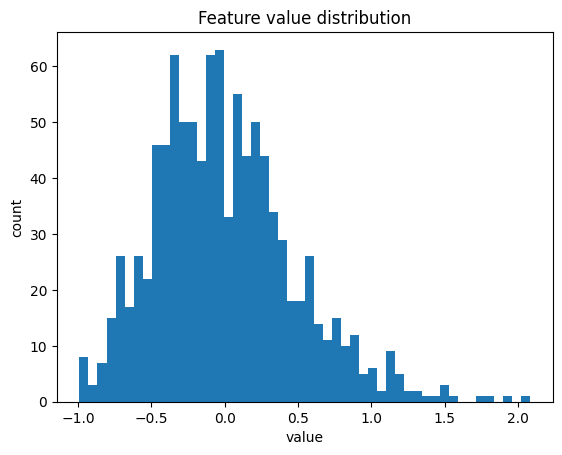

Rows in mapping: 160
Missing files: 0
Bad shapes: 160  expected (1280,)
NaN or Inf vectors: 0
Example bad shape: [('Features/MNASNet/HandGesture/CurtainGesture/Hamad/CGH1.npy', (1000,)), ('Features/MNASNet/HandGesture/CurtainGesture/Hamad/CGH2.npy', (1000,)), ('Features/MNASNet/HandGesture/CurtainGesture/Hamad/CGH3.npy', (1000,))]
Image: Processed Dataset/ProcessedHandGesture/LightGesture/Obaid/LGO6.png
Label: light
User: obaid
Feature shape: (1000,)
First 20 values: [-0.0158 -0.5674  0.1122  0.0677  0.2852 -0.1349 -0.1482 -0.3948 -0.3091
 -0.686  -0.179   0.0013 -0.384  -0.6147 -0.3943 -0.1243 -0.4824 -0.293
 -0.0631 -0.7959]
Stats min max mean std: -1.17578125 2.24609375 0.00011118697875645012 0.4639372229576111


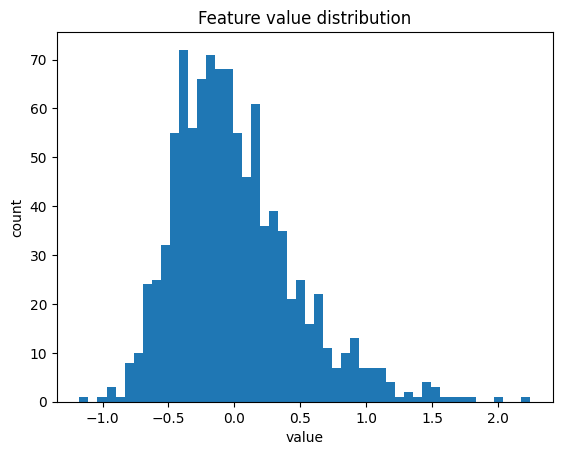

In [66]:
# Check the mapping CSV and feature files for issues, and print a random example
def check_features(map_csv):
    df = pd.read_csv(map_csv)
    print(f"Rows in mapping: {len(df)}")

    missing = []
    bad_shape = []
    nan_inf = 0

    for i, row in df.iterrows():
        fp = (ROOT / row["feature_path"])
        if not fp.exists():
            missing.append(row["feature_path"])
            continue
        v = np.load(fp)
        if v.shape != (FEATURE_DIM,):
            bad_shape.append((row["feature_path"], v.shape))
        if not np.isfinite(v).all():
            nan_inf += 1

    print(f"Missing files: {len(missing)}")
    print(f"Bad shapes: {len(bad_shape)}  expected {(FEATURE_DIM,)}")
    print(f"NaN or Inf vectors: {nan_inf}")

    if missing:
        print("Example missing:", missing[:3])
    if bad_shape:
        print("Example bad shape:", bad_shape[:3])



    row = df.sample(1, random_state=SEED).iloc[0]  # random pick
    fp = ROOT / row["feature_path"]
    v = np.load(fp)

    print("Image:", row["image_path"])
    print("Label:", row["label"])
    if "user_id" in row:
        print("User:", row["user_id"])
    print("Feature shape:", v.shape)
    print("First 20 values:", np.round(v[:20], 4))
    print("Stats min max mean std:", float(v.min()), float(v.max()), float(v.mean()), float(v.std()))

    plt.figure()
    plt.hist(v, bins=50)
    plt.title("Feature value distribution")
    plt.xlabel("value")
    plt.ylabel("count")
    plt.show()

# Feature example check
check_features(MAP_CSV_FALL)
check_features(MAP_CSV_GEST)

In [299]:
# ---------- Variables Declaration ----------
TRAIN_BATCH_SIZE = 32
EPOCHS = 50
LR = 1e-3
WEIGHT_DECAY = 1e-4
HIDDEN_DIM = 64
DROPOUT = 0.3
APPLY_STANDARDIZE = True     # fit on train only, apply to val/test
APPLY_L2 = False             # optional per-sample L2 normalize
MODELS_ROOT = ROOT / "Models"  # save trained models here

In [300]:
# ---------- Training and evaluation of MLP classifier on extracted features ----------

# ---- Repro utilities (use existing SEED; no reinit of device) ----
def seed_everything(seed: int):
    import random, os
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ---- Data loading from mapping CSV ----
def load_features_from_map(map_csv: Path, has_user: bool):
    df = pd.read_csv(map_csv)
    X = np.stack([np.load((ROOT / fp).as_posix()) for fp in df["feature_path"]]).astype(np.float32)
    y_text = df["label"].astype(str).values
    enc = LabelEncoder()
    y = enc.fit_transform(y_text)
    meta = {"labels_text": y_text, "label_encoder": enc}
    if has_user and "user_id" in df.columns:
        meta["user_id"] = df["user_id"].astype(str).values
    meta["image_path"] = df["image_path"].astype(str).values
    return X, y, meta

# Dataset class for loading numpy features
class NumpyFeatDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y).long()
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.X[i], self.y[i]

# Simple MLP classifier
class MLP(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, HIDDEN_DIM),
            nn.ReLU(inplace=True),
            nn.Dropout(DROPOUT),
            nn.Linear(HIDDEN_DIM, num_classes),
        )
    def forward(self, x): return self.net(x)

# Apply scaling (standardization + L2 normalization)
def apply_scaling(X_train, X_val, X_test):
    scaler = None
    if APPLY_STANDARDIZE:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)
    if APPLY_L2:
        X_train = X_train / (np.linalg.norm(X_train, axis=1, keepdims=True) + 1e-8)
        X_val   = X_val   / (np.linalg.norm(X_val,   axis=1, keepdims=True) + 1e-8)
        X_test  = X_test  / (np.linalg.norm(X_test,  axis=1, keepdims=True) + 1e-8)
    return X_train.astype(np.float32), X_val.astype(np.float32), X_test.astype(np.float32), scaler

# Train one split (train/val) and return best metrics + state
def train_one_split(X_train, y_train, X_val, y_val, num_classes, seed):
    # reuse earlier helpers/vars: seed_everything, apply_scaling, FEATURE_DIM, device,
    # TRAIN_BATCH_SIZE, EPOCHS, LR, WEIGHT_DECAY, DROPOUT, HIDDEN_DIM
    seed_everything(seed)

    X_train_s, X_val_s, X_val_for_eval, scaler = apply_scaling(X_train, X_val, X_val.copy())

    train_ds = NumpyFeatDataset(X_train_s, y_train)
    val_ds   = NumpyFeatDataset(X_val_s,   y_val)

    train_loader = torch.utils.data.DataLoader(
        train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=0
    )
    val_loader   = torch.utils.data.DataLoader(
        val_ds,   batch_size=TRAIN_BATCH_SIZE, shuffle=False, num_workers=0
    )

    model = MLP(FEATURE_DIM, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    best = {"acc": 0.0, "state": None}

    for _ in range(1, EPOCHS + 1):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device); yb = yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            optimizer.zero_grad(); loss.backward(); optimizer.step()

        # quick val
        model.eval()
        all_logits, all_y = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                all_logits.append(model(xb).cpu())
                all_y.append(yb)
        logits = torch.cat(all_logits); y_true = torch.cat(all_y)
        y_pred = logits.argmax(1)
        acc = (y_pred == y_true).float().mean().item()
        if acc > best["acc"]:
            best["acc"] = acc
            best["state"] = {k: v.cpu() for k, v in model.state_dict().items()}

    # final metrics with best
    model.load_state_dict(best["state"])
    model.eval()
    with torch.no_grad():
        logits = model(torch.from_numpy(X_val_s).to(device)).cpu().numpy()
    y_pred = logits.argmax(1)
    from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
    cm = confusion_matrix(y_val, y_pred)
    acc = accuracy_score(y_val, y_pred)
    f1m = f1_score(y_val, y_pred, average="macro")

    return {
        "acc": acc,
        "f1_macro": f1m,
        "cm": cm,
        "y_pred": y_pred,
        "state": best["state"],
        "scaler": scaler,
    }

# Save all artifacts from one run
def save_run_artifacts(save_dir: Path,
                       state_dict: dict,
                       scaler,
                       label_encoder,
                       config: dict,
                       metrics: dict,
                       cm: np.ndarray,
                       class_names: list):
    save_dir.mkdir(parents=True, exist_ok=True)

    # model
    torch.save(state_dict, save_dir / "model_state.pt")

    # scaler + label encoder
    with open(save_dir / "scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)
    with open(save_dir / "label_encoder.pkl", "wb") as f:
        pickle.dump(label_encoder, f)

    # config + metrics
    with open(save_dir / "config.json", "w") as f:
        json.dump(config, f, indent=2)
    with open(save_dir / "metrics.json", "w") as f:
        json.dump(metrics, f, indent=2)

    # confusion matrix (csv + png)
    np.savetxt(save_dir / "confusion_matrix.csv", cm, fmt="%d", delimiter=",")
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    plt.colorbar(im, ax=ax)
    ax.set_xticks(range(len(class_names))); ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticks(range(len(class_names))); ax.set_yticklabels(class_names)
    # annotate
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i, j]), ha="center", va="center", fontsize=8)
    fig.tight_layout()
    fig.savefig(save_dir / "confusion_matrix.png", dpi=160)
    plt.close(fig)

In [301]:
# ---------- Variables Declaration for EffB7 ----------
MAP_CSV_FALL = ROOT / "FallDetectionFeaturesEffB7.csv"
MAP_CSV_GEST = ROOT / "HandGestureFeaturesEffB7.csv"
FEATURES_ROOT = ROOT / "Features" / "EffB7"
FEATURE_DIM = 2560
MODELS_ROOT = ROOT / "ModelsB7"

In [302]:
# Train and Test Fall 80/20 across 5 seeds
N_SEEDS = 5
TEST_SIZE = 0.2

X_fall, y_fall, meta_fall = load_features_from_map(MAP_CSV_FALL, has_user=False)
class_names_fall = meta_fall["label_encoder"].classes_.tolist()
num_classes_fall = len(class_names_fall)

results_fall = []
for i, seed in enumerate(range(SEED, SEED + N_SEEDS), 1):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=seed)
    train_idx, val_idx = next(sss.split(X_fall, y_fall))

    res = train_one_split(
        X_fall[train_idx], y_fall[train_idx],
        X_fall[val_idx],   y_fall[val_idx],
        num_classes_fall, seed
    )
    results_fall.append(res)
    print(f"[Fall] Run {i}: acc={res['acc']:.3f}  f1_macro={res['f1_macro']:.3f}")

    # save
    save_dir = MODELS_ROOT / "Fall" / f"seed_{seed}"
    cfg = {
        "dataset": "Fall",
        "seed": seed,
        "feature_dim": FEATURE_DIM,
        "hidden_dim": HIDDEN_DIM,
        "dropout": DROPOUT,
        "epochs": EPOCHS,
        "lr": LR,
        "weight_decay": WEIGHT_DECAY,
        "apply_standardize": APPLY_STANDARDIZE,
        "apply_l2": APPLY_L2,
        "classes": class_names_fall,
    }
    metrics = {"acc": float(res["acc"]), "f1_macro": float(res["f1_macro"])}
    save_run_artifacts(save_dir, res["state"], res["scaler"],
                       meta_fall["label_encoder"], cfg, metrics, res["cm"], class_names_fall)

print("Fall avg acc:", np.mean([r["acc"] for r in results_fall]).round(3))
print("Fall avg f1 :", np.mean([r["f1_macro"] for r in results_fall]).round(3))

[Fall] Run 1: acc=0.850  f1_macro=0.847
[Fall] Run 2: acc=0.950  f1_macro=0.947
[Fall] Run 3: acc=0.900  f1_macro=0.896
[Fall] Run 4: acc=1.000  f1_macro=1.000
[Fall] Run 5: acc=0.950  f1_macro=0.947
Fall avg acc: 0.93
Fall avg f1 : 0.927


In [303]:
# Train and Test Gesture LOSO (train on 3 users, test on 1)
X_gest, y_gest, meta_gest = load_features_from_map(MAP_CSV_GEST, has_user=True)
users = np.array(meta_gest["user_id"])
class_names_gest = meta_gest["label_encoder"].classes_.tolist()
num_classes_gest = len(class_names_gest)

unique_users = sorted(np.unique(users))
results_gest_loso = []

for u in unique_users:
    test_mask = (users == u)
    train_mask = ~test_mask

    res = train_one_split(
        X_gest[train_mask], y_gest[train_mask],
        X_gest[test_mask],  y_gest[test_mask],
        num_classes_gest, seed=SEED
    )
    results_gest_loso.append((u, res))
    print(f"[Gesture LOSO] Holdout {u}: acc={res['acc']:.3f}  f1_macro={res['f1_macro']:.3f}")

    save_dir = MODELS_ROOT / "Gesture_LOSO" / f"user_{u}"
    cfg = {
        "dataset": "Gesture_LOSO",
        "holdout_user": u,
        "seed": SEED,
        "feature_dim": FEATURE_DIM,
        "hidden_dim": HIDDEN_DIM,
        "dropout": DROPOUT,
        "epochs": EPOCHS,
        "lr": LR,
        "weight_decay": WEIGHT_DECAY,
        "apply_standardize": APPLY_STANDARDIZE,
        "apply_l2": APPLY_L2,
        "classes": class_names_gest,
    }
    metrics = {"acc": float(res["acc"]), "f1_macro": float(res["f1_macro"])}
    save_run_artifacts(save_dir, res["state"], res["scaler"],
                       meta_gest["label_encoder"], cfg, metrics, res["cm"], class_names_gest)

print("Gesture LOSO avg acc:", np.mean([r[1]['acc'] for r in results_gest_loso]).round(3))
print("Gesture LOSO avg f1 :", np.mean([r[1]['f1_macro'] for r in results_gest_loso]).round(3))

[Gesture LOSO] Holdout hamad: acc=0.900  f1_macro=0.893
[Gesture LOSO] Holdout mohammad: acc=0.950  f1_macro=0.950
[Gesture LOSO] Holdout obaid: acc=0.950  f1_macro=0.950
[Gesture LOSO] Holdout saif: acc=0.950  f1_macro=0.949
Gesture LOSO avg acc: 0.938
Gesture LOSO avg f1 : 0.936


In [304]:
# Train and Test Gesture 80/20 across 5 seeds (mixed users)
N_SEEDS = 5
TEST_SIZE = 0.2

results_gest_mix = []
for i, seed in enumerate(range(SEED, SEED + N_SEEDS), 1):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=seed)
    train_idx, val_idx = next(sss.split(X_gest, y_gest))

    res = train_one_split(
        X_gest[train_idx], y_gest[train_idx],
        X_gest[val_idx],   y_gest[val_idx],
        num_classes_gest, seed
    )
    results_gest_mix.append(res)
    print(f"[Gesture Mixed] Run {i}: acc={res['acc']:.3f}  f1_macro={res['f1_macro']:.3f}")

    save_dir = MODELS_ROOT / "Gesture_Mixed" / f"seed_{seed}"
    cfg = {
        "dataset": "Gesture_Mixed",
        "seed": seed,
        "feature_dim": FEATURE_DIM,
        "hidden_dim": HIDDEN_DIM,
        "dropout": DROPOUT,
        "epochs": EPOCHS,
        "lr": LR,
        "weight_decay": WEIGHT_DECAY,
        "apply_standardize": APPLY_STANDARDIZE,
        "apply_l2": APPLY_L2,
        "classes": class_names_gest,
    }
    metrics = {"acc": float(res["acc"]), "f1_macro": float(res["f1_macro"])}
    save_run_artifacts(save_dir, res["state"], res["scaler"],
                       meta_gest["label_encoder"], cfg, metrics, res["cm"], class_names_gest)

print("Gesture Mixed avg acc:", np.mean([r["acc"] for r in results_gest_mix]).round(3))
print("Gesture Mixed avg f1 :", np.mean([r["f1_macro"] for r in results_gest_mix]).round(3))

[Gesture Mixed] Run 1: acc=1.000  f1_macro=1.000
[Gesture Mixed] Run 2: acc=1.000  f1_macro=1.000
[Gesture Mixed] Run 3: acc=1.000  f1_macro=1.000
[Gesture Mixed] Run 4: acc=1.000  f1_macro=1.000
[Gesture Mixed] Run 5: acc=0.969  f1_macro=0.969
Gesture Mixed avg acc: 0.994
Gesture Mixed avg f1 : 0.994


In [305]:
# ---------- Variables Declaration for Lite0 ----------
MAP_CSV_FALL = ROOT / "FallDetectionFeaturesEffLite0.csv"
MAP_CSV_GEST = ROOT / "HandGestureFeaturesEffLite0.csv"
FEATURES_ROOT = ROOT / "Features" / "EffLite0"
FEATURE_DIM = 1280
MODELS_ROOT = ROOT / "ModelsLite0"

In [306]:
# Train and Test Fall 80/20 across 5 seeds
N_SEEDS = 5
TEST_SIZE = 0.2

X_fall, y_fall, meta_fall = load_features_from_map(MAP_CSV_FALL, has_user=False)
class_names_fall = meta_fall["label_encoder"].classes_.tolist()
num_classes_fall = len(class_names_fall)

results_fall = []
for i, seed in enumerate(range(SEED, SEED + N_SEEDS), 1):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=seed)
    train_idx, val_idx = next(sss.split(X_fall, y_fall))

    res = train_one_split(
        X_fall[train_idx], y_fall[train_idx],
        X_fall[val_idx],   y_fall[val_idx],
        num_classes_fall, seed
    )
    results_fall.append(res)
    print(f"[Fall] Run {i}: acc={res['acc']:.3f}  f1_macro={res['f1_macro']:.3f}")

    # save
    save_dir = MODELS_ROOT / "Fall" / f"seed_{seed}"
    cfg = {
        "dataset": "Fall",
        "seed": seed,
        "feature_dim": FEATURE_DIM,
        "hidden_dim": HIDDEN_DIM,
        "dropout": DROPOUT,
        "epochs": EPOCHS,
        "lr": LR,
        "weight_decay": WEIGHT_DECAY,
        "apply_standardize": APPLY_STANDARDIZE,
        "apply_l2": APPLY_L2,
        "classes": class_names_fall,
    }
    metrics = {"acc": float(res["acc"]), "f1_macro": float(res["f1_macro"])}
    save_run_artifacts(save_dir, res["state"], res["scaler"],
                       meta_fall["label_encoder"], cfg, metrics, res["cm"], class_names_fall)

print("Fall avg acc:", np.mean([r["acc"] for r in results_fall]).round(3))
print("Fall avg f1 :", np.mean([r["f1_macro"] for r in results_fall]).round(3))

[Fall] Run 1: acc=0.950  f1_macro=0.949
[Fall] Run 2: acc=1.000  f1_macro=1.000
[Fall] Run 3: acc=1.000  f1_macro=1.000
[Fall] Run 4: acc=1.000  f1_macro=1.000
[Fall] Run 5: acc=1.000  f1_macro=1.000
Fall avg acc: 0.99
Fall avg f1 : 0.99


In [307]:
# Train and Test Gesture LOSO (train on 3 users, test on 1)
X_gest, y_gest, meta_gest = load_features_from_map(MAP_CSV_GEST, has_user=True)
users = np.array(meta_gest["user_id"])
class_names_gest = meta_gest["label_encoder"].classes_.tolist()
num_classes_gest = len(class_names_gest)

unique_users = sorted(np.unique(users))
results_gest_loso = []

for u in unique_users:
    test_mask = (users == u)
    train_mask = ~test_mask

    res = train_one_split(
        X_gest[train_mask], y_gest[train_mask],
        X_gest[test_mask],  y_gest[test_mask],
        num_classes_gest, seed=SEED
    )
    results_gest_loso.append((u, res))
    print(f"[Gesture LOSO] Holdout {u}: acc={res['acc']:.3f}  f1_macro={res['f1_macro']:.3f}")

    save_dir = MODELS_ROOT / "Gesture_LOSO" / f"user_{u}"
    cfg = {
        "dataset": "Gesture_LOSO",
        "holdout_user": u,
        "seed": SEED,
        "feature_dim": FEATURE_DIM,
        "hidden_dim": HIDDEN_DIM,
        "dropout": DROPOUT,
        "epochs": EPOCHS,
        "lr": LR,
        "weight_decay": WEIGHT_DECAY,
        "apply_standardize": APPLY_STANDARDIZE,
        "apply_l2": APPLY_L2,
        "classes": class_names_gest,
    }
    metrics = {"acc": float(res["acc"]), "f1_macro": float(res["f1_macro"])}
    save_run_artifacts(save_dir, res["state"], res["scaler"],
                       meta_gest["label_encoder"], cfg, metrics, res["cm"], class_names_gest)

print("Gesture LOSO avg acc:", np.mean([r[1]['acc'] for r in results_gest_loso]).round(3))
print("Gesture LOSO avg f1 :", np.mean([r[1]['f1_macro'] for r in results_gest_loso]).round(3))

[Gesture LOSO] Holdout hamad: acc=0.975  f1_macro=0.975
[Gesture LOSO] Holdout mohammad: acc=1.000  f1_macro=1.000
[Gesture LOSO] Holdout obaid: acc=1.000  f1_macro=1.000
[Gesture LOSO] Holdout saif: acc=0.800  f1_macro=0.790
Gesture LOSO avg acc: 0.944
Gesture LOSO avg f1 : 0.941


In [308]:
# Train and Test Gesture 80/20 across 5 seeds (mixed users)
N_SEEDS = 5
TEST_SIZE = 0.2

results_gest_mix = []
for i, seed in enumerate(range(SEED, SEED + N_SEEDS), 1):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=seed)
    train_idx, val_idx = next(sss.split(X_gest, y_gest))

    res = train_one_split(
        X_gest[train_idx], y_gest[train_idx],
        X_gest[val_idx],   y_gest[val_idx],
        num_classes_gest, seed
    )
    results_gest_mix.append(res)
    print(f"[Gesture Mixed] Run {i}: acc={res['acc']:.3f}  f1_macro={res['f1_macro']:.3f}")

    save_dir = MODELS_ROOT / "Gesture_Mixed" / f"seed_{seed}"
    cfg = {
        "dataset": "Gesture_Mixed",
        "seed": seed,
        "feature_dim": FEATURE_DIM,
        "hidden_dim": HIDDEN_DIM,
        "dropout": DROPOUT,
        "epochs": EPOCHS,
        "lr": LR,
        "weight_decay": WEIGHT_DECAY,
        "apply_standardize": APPLY_STANDARDIZE,
        "apply_l2": APPLY_L2,
        "classes": class_names_gest,
    }
    metrics = {"acc": float(res["acc"]), "f1_macro": float(res["f1_macro"])}
    save_run_artifacts(save_dir, res["state"], res["scaler"],
                       meta_gest["label_encoder"], cfg, metrics, res["cm"], class_names_gest)

print("Gesture Mixed avg acc:", np.mean([r["acc"] for r in results_gest_mix]).round(3))
print("Gesture Mixed avg f1 :", np.mean([r["f1_macro"] for r in results_gest_mix]).round(3))

[Gesture Mixed] Run 1: acc=1.000  f1_macro=1.000
[Gesture Mixed] Run 2: acc=1.000  f1_macro=1.000
[Gesture Mixed] Run 3: acc=1.000  f1_macro=1.000
[Gesture Mixed] Run 4: acc=0.969  f1_macro=0.969
[Gesture Mixed] Run 5: acc=1.000  f1_macro=1.000
Gesture Mixed avg acc: 0.994
Gesture Mixed avg f1 : 0.994
